<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/MRF_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

# Load Data and Create Sample Datasets

In [2]:
# Function to create two datasets from global df that are one-hot encoded
def OHE_sample(sample_df, features_to_OHE: list):
  for feature in features_to_OHE:
    feature_OHE = pd.get_dummies(prefix = feature,data= sample_df[feature])
    sample_df = pd.concat([sample_df,feature_OHE],axis=1)
  sample_df.drop(features_to_OHE,axis=1,inplace=True)
  print(sample_df)
  return sample_df

In [3]:
# Load global relation
df = pd.read_csv("data_8.csv")
print(df.shape)

#Create two datasets containing AB and BC
num_samples = 1000
sample1_df = df[['A','B']].sample(n=num_samples, random_state=2)
print(sample1_df.head())
sample2_df = df[['B','C']].sample(n=num_samples, random_state=3)
print(sample2_df.head())

# Make A,B,C inputs all 8 bits
#Does data need to respect Gaussian distribution?
#Could add noise so not exactly OHE: 0.01...0.9...0.01
sample1_OHE = OHE_sample(sample1_df,['A','B'])
sample2_OHE = OHE_sample(sample2_df,['B','C'])

# Could onvert pandas dataframes to list of lists of lists
# [ [[OHE A1],[OHE B1]], [[OHE A2],[OHE B2]], ...  ]

(5056, 3)
      A  B
4333  7  6
2638  6  4
2254  4  4
3116  5  5
3998  6  6
      B  C
4616  7  6
2276  4  6
3448  5  4
4064  6  5
1204  2  3
      A_0  A_1  A_2  A_3  A_4  A_5  A_6  ...  B_1  B_2  B_3  B_4  B_5  B_6  B_7
4333    0    0    0    0    0    0    0  ...    0    0    0    0    0    1    0
2638    0    0    0    0    0    0    1  ...    0    0    0    1    0    0    0
2254    0    0    0    0    1    0    0  ...    0    0    0    1    0    0    0
3116    0    0    0    0    0    1    0  ...    0    0    0    0    1    0    0
3998    0    0    0    0    0    0    1  ...    0    0    0    0    0    1    0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1857    0    1    0    0    0    0    0  ...    0    0    1    0    0    0    0
3813    0    0    0    0    0    1    0  ...    0    0    0    0    0    1    0
604     1    0    0    0    0    0    0  ...    1    0    0    0    0    0    0
621     1    0    0    0    0    0    0  ...    1    0    

# Global Relation Bayesian Network Ground Truth

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


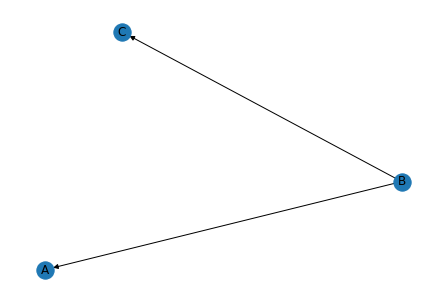

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Eliminating: B: 100%|██████████| 1/1 [00:00<00:00, 434.82it/s]


 Global Relation Ground Truth

 P(C|A=0) 
 Ground Truth
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.2500 |
+------+----------+
| C(1) |   0.2500 |
+------+----------+
| C(2) |   0.2500 |
+------+----------+
| C(3) |   0.2500 |
+------+----------+
| C(4) |   0.0000 |
+------+----------+
| C(5) |   0.0000 |
+------+----------+
| C(6) |   0.0000 |
+------+----------+
| C(7) |   0.0000 |
+------+----------+


In [4]:
!pip install pgmpy==0.1.9
import pgmpy
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

def groundTruth(df,evidence):
    """
    Extracts ground truth from global relation
    """
    model = BayesianModel([('B', 'A'), ('B', 'C')])
    model.fit(df)
    nx.draw(model, with_labels=True)
    plt.show()
    print('\n Global Relation Ground Truth')
    #for var in model.nodes():
    #    print(model.get_cpds(var))
    inference = VariableElimination(model)
    q = inference.query(variables=['A','B','C'])
    joint_prob = q.values.flatten()
    #print(joint_prob)
    #print('\n P(A,B,C) \n Ground Truth')
    #print(q)
    q = inference.query(variables=['C'], evidence=evidence)
    print('\n P(C|A=0) \n Ground Truth')
    print(q)

groundTruth(df,{'A':0})

# VAE-MRF Architecture

In [5]:
# VAE Parameters
num = 8 # digits from 0 to 7
latent_dims = 3 # Latent z_A,z_B,z_C all are all same dimension size
num_epochs = 1000
batch_size = 64
learning_rate = 1e-3
use_gpu = True
variational_beta = 0.00001 #tuned

In [6]:
class VariationalAutoencoder_MRF(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1A = nn.Linear(num, latent_dims)
        self.fc_muA = nn.Linear(latent_dims, latent_dims)
        self.fc_logvarA = nn.Linear(latent_dims, latent_dims)
        self.fc_outA = nn.Linear(latent_dims,num)
        
        self.fc1B = nn.Linear(num, latent_dims)
        self.fc_muB = nn.Linear(latent_dims, latent_dims)
        self.fc_logvarB = nn.Linear(latent_dims, latent_dims)
        self.fc_outB = nn.Linear(latent_dims,num)

        #Covariance: Sigma_{AB} = Sigma_{BA}^T
        # Sigma_AB is the top right term
        #self.covarianceAB = nn.Parameter(torch.zeros(latent_dims,latent_dims),requires_grad=True)
        #self.covarianceAB = torch.randn(size=(latent_dims,latent_dims), requires_grad=True))
        self.covarianceAB = torch.randn(size=(latent_dims,latent_dims))
        #print(self.covarianceAB)
        #print(torch.inverse(self.covarianceAB))
        self.covarianceAB = torch.nn.Parameter(self.covarianceAB,requires_grad=True)
        #self.covarianceAB = nn.Parameter(torch.rand(size=(latent_dims,latent_dims), requires_grad=True))
        #print(self.covarianceAB)

    def reparameterize(self, mu, logvar): #mu.size() = batch_size, 3
        std = torch.exp(0.5*logvar) #batch_size,3  ,3
        eps = torch.randn_like(std) #want batch_size,3 not #batch_size,3,3
        print('mu,std,eps size')
        print(mu.size())
        print(std.size())
        print(eps.size())
        return mu + eps*std # batch_size,3


    # Conditional of Multivariate Gaussian: matrix cookbook 353 and 354
    def conditional(self, muA, logvarA, muB, logvarB, z, attribute):
        #Convert logvarA vector to diagonal matrix
        logvarA = torch.exp(0.5*logvarA)
        logvarB = torch.exp(0.5*logvarB)
        covarianceA = torch.diag_embed(logvarA) #batch_size,3,3
        covarianceB = torch.diag_embed(logvarB)
        #self.covarianceAB = torch.nn.Parameter(0.5* torch.exp(self.covarianceAB),requires_grad=True)
        print(self.covarianceAB)
        print('covarianceA')
        print(covarianceA)
        muA = muA.unsqueeze(2)
        muB = muB.unsqueeze(2)
        z = z.unsqueeze(2)
        if attribute == 'A':
          mu_cond = muA + torch.matmul(torch.matmul(self.covarianceAB, 
                                                    torch.inverse(covarianceB)),
                                   (z - muB)) # z is zB
          logvar_cond = covarianceA - torch.matmul(torch.matmul(self.covarianceAB, 
                                                      torch.inverse(covarianceB)),
                                             torch.transpose(self.covarianceAB,0,1))
          logvar_cond = logvar_cond + 100*torch.eye(latent_dims)
        elif attribute == 'B':
          mu_cond = muB + torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1),
                                                    torch.inverse(covarianceA)), 
                                       (z - muA)) # z is zA
          logvar_cond = covarianceB - torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1), 
                                                              torch.inverse(covarianceA)),
                                                 self.covarianceAB)
          logvar_cond = logvar_cond + 100*torch.eye(latent_dims)
        print('mu_cond, logvar_cond size')
        mu_cond = mu_cond.squeeze(2)
        print(mu_cond.size()) # 64x3x1
        print(mu_cond)
        print(logvar_cond.size()) #64x3x3
        print(logvar_cond)
        distrib = MultivariateNormal(loc=mu_cond, covariance_matrix=logvar_cond)
        sample = distrib.rsample()
        print('Multivariate Normal size')
        print(sample.size())
        return sample
        #return self.reparameterize(mu_cond, logvar_cond) # logvar_cond is not a diagonal covariance matrix
        #VAE reparameterization trick with non-diagonal covariance?
        #https://stats.stackexchange.com/questions/388620/variational-autoencoder-and-covariance-matrix

    def encode(self, x, attribute):
        if attribute == 'A':
          h1 = torch.sigmoid(self.fc1A(x))
          return self.fc_muA(h1), self.fc_logvarA(h1)
        elif attribute == 'B':
          h1 = torch.sigmoid(self.fc1B(x))
          return self.fc_muB(h1), self.fc_logvarB(h1)
        print('ERROR')
        return -100

    def decode(self, z, attribute):
        if z.size()[0] == latent_dims: #resize from [3] to [1,3] if fed only a single sample
            z = z.view(1, latent_dims)
        softmax = nn.Softmax(dim=1)
        if attribute == 'A':
          reconA = softmax(self.fc_outA(z))
          return reconA
        elif attribute == 'B':
          reconB = softmax(self.fc_outB(z))
          return reconB
        print('ERROR')
        return -100
    
    def forward(self, xA, xB, attribute):
        muA, logvarA = self.encode(xA, attribute='A') #logvar is size [64,3]
        muB, logvarB = self.encode(xB, attribute='B')
        if attribute == 'A':
          zB = self.reparameterize(muB, logvarB)
          print('zB size')
          print(zB.size())
          zA = self.conditional(muA, logvarA, muB, logvarB, zB, attribute)
          print('zA size')
          print(zA.size())
          return self.decode(zA,attribute), muA, logvarA
        elif attribute == 'B':
          zA = self.reparameterize(muA, logvarA)
          zB = self.conditional(muA, logvarA, muB, logvarB, zA, attribute)
          return self.decode(zB,attribute), muB, logvarB
        print('ERROR')
        return -100

def vae_loss(batch_recon, batch_targets, mu, logvar):
  print('batch_targets, batch_recon size')
  print(batch_targets.size())
  print(batch_recon.size())
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, batch_targets)
  #print(CE)
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

Koller Equation 7.3: \\
$P(X,Y) = Normal
\left(\left( \begin{array}{r} \mu_X \\ \mu_Y \end{array} \right), 
\left[ \begin{array}{r} \Sigma_{XX} & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{YY} \end{array} \right] \right) $ 

From Koller Theorem 7.4: \\
$P(Y|X) = Normal (\beta_0 + \beta^TX, \sigma^2)$ \\
such that \\
$\beta_0 = \mu_Y - \Sigma_{YX} \Sigma^{-1}_{XX}\mu_X$ \\
$\beta = \Sigma^{-1}_{XX} \Sigma_{YX}$ \\
$\sigma^2 = \Sigma_{YY} - \Sigma_{YX}\Sigma^{-1}_{XX}\Sigma_{XY}$

which is equivalent to the Matrix Cookbook (353 and 354).

A symmetric matrix is positive definite if:

- all the diagonal entries are positive, and
- each diagonal entry is greater than the sum of the absolute values of all other entries in the corresponding row/column.


In [11]:
def trainVAE(VAE):
  VAE.train() #set model mode to train
  xA = sample1_OHE.filter(like='A', axis=1).values
  xB = sample1_OHE.filter(like='B', axis=1).values
  #print(xA.shape)

  #sample2_OHE when do BC plate
  
  indsA = list(range(xA.shape[0]))
  indsB = list(range(xB.shape[0]))
  N = num_samples # 1000
  freq = num_epochs // 10 # floor division

  loss_hist = []
  xA = Variable(torch.from_numpy(xA))
  xB = Variable(torch.from_numpy(xB))
  
  for epoch in range(num_epochs):
      print('epoch' + str(epoch))
      indsA = np.random.permutation(indsA)
      xA = xA[indsA]
      xA = xA.to(device)
      indsB = np.random.permutation(indsB)
      xB = xB[indsB]
      xB = xB.to(device)
      
      loss = 0
      CE = 0
      KLd = 0
      num_batches = N / batch_size
      for b in range(0, N, batch_size):
          #get the mini-batch
          x_batchA = xA[b: b+batch_size]
          x_batchB = xB[b: b+batch_size]
          
          #feed forward
          batch_reconA,latent_muA,latent_logvarA = VAE.forward(x_batchA.float(),x_batchB.float(),attribute='A')
          batch_reconB,latent_muB,latent_logvarB = VAE.forward(x_batchA.float(),x_batchB.float(),attribute='B')
          print('batch_recon size')
          print(batch_reconA.size())
          # Error
          #Convert x_batchA and x_batchB from OHE vectors to single scalar
          # max returns index location of max value in each sample of batch 
          _, xA_batch_targets = x_batchA.max(dim=1)
          _, xB_batch_targets = x_batchB.max(dim=1)
          train_CE_A, train_KLd_A, train_loss_A = vae_loss(batch_reconA, xA_batch_targets, latent_muA, latent_logvarA)
          train_CE_B, train_KLd_B, train_loss_B = vae_loss(batch_reconB, xB_batch_targets, latent_muB, latent_logvarB)
          #print(batch_reconA.size())
          #print(xA_batch_targets.size())
          loss += train_loss_A.item() / N # update epoch loss
          loss += train_loss_B.item() / N
          CE += train_CE_A.item() / N
          CE += train_CE_B.item() / N 
          KLd += train_KLd_A.item() / N
          KLd += train_KLd_B.item() / N

          #Backprop the error, compute the gradient
          optimizer.zero_grad()
          train_loss = train_loss_A + train_loss_B
          train_loss.backward()
          
          #update parameters based on gradient
          optimizer.step()
          
      #Record loss per epoch        
      loss_hist.append(loss)
      
      if epoch % freq == 0:
          print()
          print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)
          
          #Test with all training data
          VAE.eval()
          train_reconA, train_muA, train_logvarA = VAE.forward(xA.float(),xB.float(), attribute='A')
          train_reconB, train_muB, train_logvarB = VAE.forward(xA.float(),xB.float(), attribute='B')
          _, xA_targets = xA.max(dim=1)
          _, xB_targets = xB.max(dim=1)
          CE_A,KLd_A,test_loss_A = vae_loss(train_reconA, xA_targets, train_muA, train_logvarA)
          CE_B,KLd_B,test_loss_B = vae_loss(train_reconB, xB_targets, train_muB, train_logvarB)

          CE = CE_A + CE_B
          Kld = KLd_A + KLd_B
          test_loss = test_loss_A + test_loss_B
          print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')
      
  print("\nTraining finished!")

## Training
Requires alternating between AB and BC samples where B is the same. What if B is not the same in both datasets? How to train?

Have a separate plate for each.
In Bayesian network, need to learn P(B),P(A|B), P(C|B). \\
In MRF need to learn factors $\phi(A,B)$ and $\phi(B,C)$.

We want to query P(C|A), therefore at test time there will be no input to the B encoder.

Do we need to incorporate the parition function Z? If want probabilities that sum to 1 then yes. But if just looking to have input into the decoders then normalizing isn't necessary?

Koller Definition 4.3: \\
$Z = \sum_{AB,BC} \phi(A,B) \times \phi(B,C)$ \\
$P(A,B,C) = \frac{1}{Z} \phi(A,B) \times \phi(B,C)$ 

To learn $\phi(A,B)$ where X = A and Y=B, need to re-construct A and B, have separate loss terms for the A decoder and the B decoder and backpropogate to learn the mean vectors, variance matrices and covariance matrices.

Need to work in log-space for numerical stability.

Assume the A encoder outputs $\mu_A, \Sigma_{AA}$ and the B encoder outputs $\mu_B, \Sigma_{BB}$.

The latent variables have structure by learning $\Sigma_{AB}, \Sigma_{BA} = \Sigma_{AB}^T$

In [2]:
# Focus on just AB Plate for now
#  use gpu if available
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
VAE = VariationalAutoencoder_MRF()
VAE = VAE.to(device)
num_params = sum(p.numel() for p in VAE.parameters() if p.requires_grad)

#for param in VAE.parameters():
#    print(type(param.data), param.size())
#print(list(VAE.parameters()))
#print(VAE.parameters)
print("Number of parameters: %d" % num_params) #8*3 + 3 = 27, 3*8 + 8 = 32 3*3+3 = 12 *2 = 24, 27+32+24=83

# optimizer object
optimizer = torch.optim.Adam(params = VAE.parameters(), lr = learning_rate)

trainVAE(VAE)

NameError: ignored